In [10]:
from importlib import reload
import flymovie as fm
#import cnn_models.siamese_cnn as cn
#import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sklearn
import tempfile
import pickle
import scipy
from importlib import reload
from sklearn.manifold import TSNE
import scipy.ndimage as ndi
import skimage as ski
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
stack = fm.read_czi('/Volumes/stad3/2022-04-08/yw-match-20220318-rpb1-gfp-em2-03.czi', swapaxes=False)

In [8]:
sm = ndi.gaussian_filter(stack, (1,10,10))

In [9]:
fm.viewer(np.where(sm < 280,0, stack), 5)

interactive(children=(Dropdown(description='Color', index=6, options=('prism', 'inferno', 'gray_r', 'Gators', …

In [10]:
t=280
f=20
pix = stack[f][sm[f] < t]

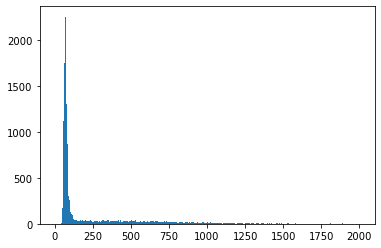

In [169]:
plt.hist(pix, 500, range=(0,2_000), log=False);

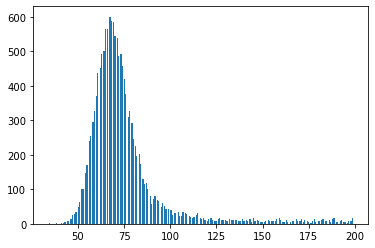

In [188]:
plt.hist(pix[pix < 200], bins=250);

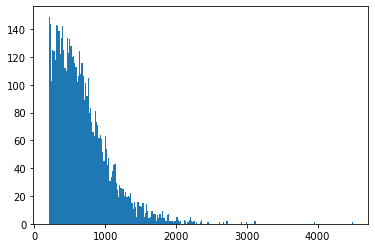

In [170]:
plt.hist(pix[pix > 200], bins=250);

In [12]:
from scipy.optimize import curve_fit
import scipy

In [30]:
scipy.stats.norm.fit(pix[pix < 100])

(69.89026206075044, 9.99016880599627)

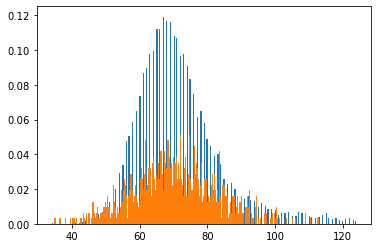

In [21]:
real = scipy.stats.norm.rvs(loc=71.47, scale=12.57, size=1_000)
plt.hist(pix[pix < 125], bins=250, density=True);
plt.hist(real, bins=250, density=True);

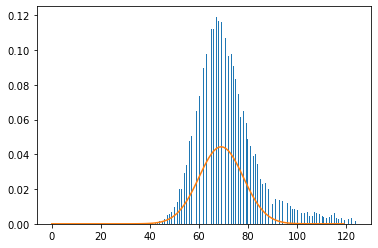

In [31]:
pdf = scipy.stats.norm.pdf(np.arange(120), loc=69, scale=9)
plt.hist(pix[pix < 125], bins=250, density=True);
plt.plot(pdf)

In [8]:
# Define the Gaussian function.
def Gauss(x, x_0, A, B):
    y = A*np.exp(-1 * B * (x - x_0) ** 2)
    return y

# Define negative binomial function.
def n_binom(x, r, p):
    comb = scipy.special.comb(
        (x + r - 1),
        (r - 1)
    )
    pdf = comb * ((1-p)**x) * (p**r)
    return pdf

def double_n_binom(x, a1, r1, p1, a2, r2, p2):
    return a1 * n_binom(x, r1, p1) + a2 * n_binom(x, r2, p2)

In [12]:
n_binom(np.arange(3), 4, 0.5)

array([0.0625 , 0.125  , 0.15625])

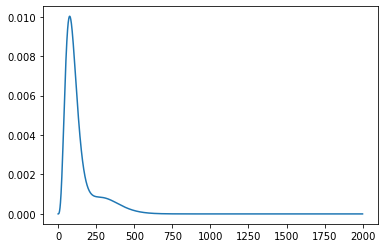

In [216]:
plt.plot(double_n_binom(np.arange(2_000), 0.2, 10, 0.03, 1, 5, 0.05))
#plt.ylim(0,0.002)

In [205]:
ydata, xdata = np.histogram(pix, bins=500, range=(0,2_000))
ydata = ydata / np.sum(ydata)

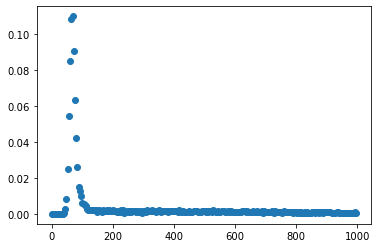

In [210]:
plt.scatter(xdata[:250], ydata[:250])

In [217]:
curve_fit(double_n_binom, xdata[:250], ydata[:250], maxfev=10_000, p0=(0.2, 10, 0.03, 1, 5, 0.05))

/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_2171/2384069478.py:12: RuntimeWarning: invalid value encountered in double_scalars
  P = comb * ((1-p)**x) * (p**r)


(array([1.55892894e+00, 1.48487787e+00, 2.63582858e-03, 2.48941977e+00,
        2.66987409e+02, 7.98526068e-01]),
 array([[ 1.65874818e-02, -1.20066680e-02, -5.12879842e-05,
         -4.95803575e-04,  3.49808288e-01,  2.10591225e-04],
        [-1.20066680e-02,  2.36891222e-02,  7.02572809e-05,
          1.14038839e-03, -8.00323492e-01, -4.81890620e-04],
        [-5.12879842e-05,  7.02572809e-05,  2.59631939e-07,
          2.13032888e-06, -1.49933835e-03, -9.00568934e-07],
        [-4.95803575e-04,  1.14038839e-03,  2.13032888e-06,
          3.14168165e-04, -2.21440899e-01, -1.33773419e-04],
        [ 3.49808288e-01, -8.00323492e-01, -1.49933835e-03,
         -2.21440899e-01,  3.70446250e+02,  2.23645215e-01],
        [ 2.10591225e-04, -4.81890620e-04, -9.00568934e-07,
         -1.33773419e-04,  2.23645215e-01,  1.35040895e-04]]))

/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_2171/2384069478.py:12: RuntimeWarning: invalid value encountered in multiply
  P = comb * ((1-p)**x) * (p**r)


(0.0, 0.01)

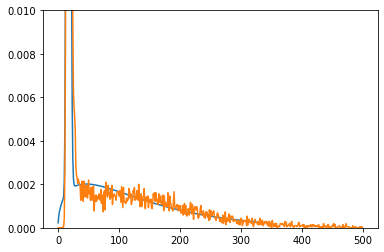

In [219]:
n=200
plt.plot(double_n_binom(xdata, 1.55892894e+00, 1.48487787e+00, 2.63582858e-03, 2.48941977e+00, 2.66987409e+02, 7.98526068e-01))
plt.plot(ydata)
plt.ylim((0,0.01))

/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_2171/2384069478.py:12: RuntimeWarning: invalid value encountered in multiply
  P = comb * ((1-p)**x) * (p**r)
/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_2171/2384069478.py:12: RuntimeWarning: invalid value encountered in multiply
  P = comb * ((1-p)**x) * (p**r)


(0.0, 0.01)

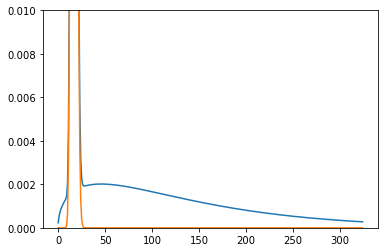

In [223]:
n=200
plt.plot(double_n_binom(xdata, 1.55892894e+00, 1.48487787e+00, 2.63582858e-03, 2.48941977e+00, 2.66987409e+02, 7.98526068e-01))
plt.plot(double_n_binom(xdata, 0, 1.48487787e+00, 2.63582858e-03, 2.48941977e+00, 2.66987409e+02, 7.98526068e-01))
#plt.plot(double_n_binom(xdata, 1.55892894e+00, 1.48487787e+00, 2.63582858e-03, 0, 2.66987409e+02, 7.98526068e-01))
plt.ylim((0,0.01))

/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_2171/2384069478.py:12: RuntimeWarning: invalid value encountered in multiply
  P = comb * ((1-p)**x) * (p**r)
/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_2171/2384069478.py:12: RuntimeWarning: invalid value encountered in multiply
  P = comb * ((1-p)**x) * (p**r)


(0.0, 0.01)

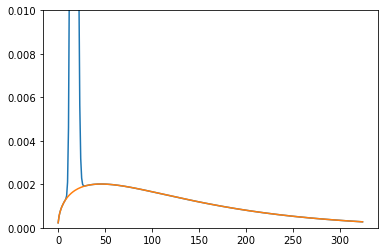

In [224]:
n=200
plt.plot(double_n_binom(xdata, 1.55892894e+00, 1.48487787e+00, 2.63582858e-03, 2.48941977e+00, 2.66987409e+02, 7.98526068e-01))
#plt.plot(double_n_binom(xdata, 0, 1.48487787e+00, 2.63582858e-03, 2.48941977e+00, 2.66987409e+02, 7.98526068e-01))
plt.plot(double_n_binom(xdata, 1.55892894e+00, 1.48487787e+00, 2.63582858e-03, 0, 2.66987409e+02, 7.98526068e-01))
plt.ylim((0,0.01))

In [226]:
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])